# Model tuning
Since our model is pretty weak, we will use Randomized Search CV in order to see if potential exists within this model.

## 1. Import packages and data

In [1]:
# Basic Import
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split

from catboost import CatBoostRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

from sklearn.metrics import r2_score, mean_absolute_error


In [2]:
filepath= "./jpn-hostel-data/clean.csv"
df = pd.read_csv(filepath)

In [3]:
df.head()

,City,price.from,summary.score,rating.band,atmosphere,cleanliness,facilities,location.y,security,staff,valueformoney,distance_km
0,Osaka,3300,9.2,Superb,8.9,9.4,9.3,8.9,9.0,9.4,9.4,2.9
1,Fukuoka-City,2600,9.5,Superb,9.4,9.7,9.5,9.7,9.2,9.7,9.5,0.7
2,Tokyo,3600,8.7,Fabulous,8.0,7.0,9.0,8.0,10.0,10.0,9.0,7.8
3,Tokyo,2600,7.4,Very Good,8.0,7.5,7.5,7.5,7.0,8.0,6.5,8.7
4,Tokyo,1500,9.4,Superb,9.5,9.5,9.0,9.0,9.5,10.0,9.5,10.5


## 2. Split train and test data

In [4]:
X = df.drop(columns=['price.from'], axis=1)
y = df['price.from']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
print("Train data shape:", X_train.shape)
print("Test data shape",X_test.shape)

Train data shape: (271, 11)
Test data shape (68, 11)


## 3. Hyperparameter tuning

In [5]:
num_features = X.select_dtypes(exclude="object").columns
cat_features = X.select_dtypes(include="object").columns

numeric_transformer = RobustScaler()
ohe_transformer = OneHotEncoder(handle_unknown='ignore', drop='first')

preprocessor = ColumnTransformer(
    transformers=[
        ("OneHotEncoder", ohe_transformer, cat_features),
         ("StandardScaler", numeric_transformer, num_features),        
    ],
    remainder='drop'
)
model = CatBoostRegressor(verbose=False, random_state=42)
pipeline = Pipeline([
        ('transformer', preprocessor),
        ('model', model)
    ])
param_grid = {
    'model__n_estimators': randint(100, 1000),  # Number of trees
    'model__max_depth': randint(3, 10),          # Depth of trees
    'model__learning_rate': [0.01, 0.05, 0.1],   # Learning rate
    'model__l2_leaf_reg': [0.1, 0.5, 1],         # L2 regularization
    'model__bagging_temperature': [0.5, 1, 2],   # Sampling temperature
    'model__subsample': [0.6, 0.8, 1],           # Portion of training data used
    'model__random_strength': [0.5, 1],          # Random strength for subspace sampling
}

In [6]:
rscv = RandomizedSearchCV(pipeline, param_grid, n_iter=50, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
rscv.fit(X_train, y_train);

In [7]:
print("Best parameters found: ", rscv.best_params_)

Best parameters found:  {'model__bagging_temperature': 0.5, 'model__l2_leaf_reg': 1, 'model__learning_rate': 0.01, 'model__max_depth': 5, 'model__n_estimators': 569, 'model__random_strength': 1, 'model__subsample': 0.8}


In [8]:
best_model = rscv.best_estimator_

## 4. Model Evaluation

In [9]:
y_pred = best_model.predict(X_test)

In [10]:
mae_score = round(mean_absolute_error(y_test, y_pred), 2)
r_squared_score = round(r2_score(y_test, y_pred), 2)

print("MAE:", mae_score)
print("R2:", r_squared_score)

MAE: 535.72
R2: 0.1


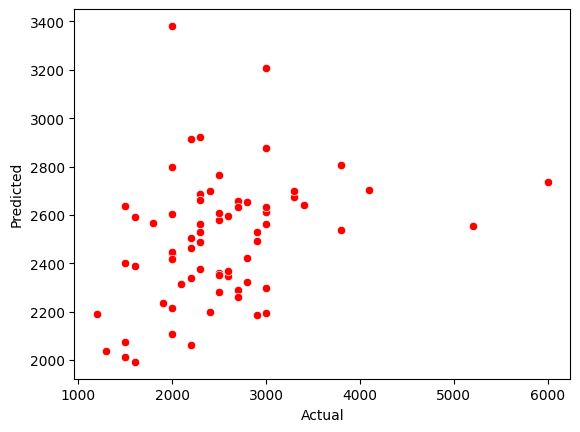

In [11]:
sns.scatterplot(x=y_test,y=y_pred, color ='red')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

In [13]:
pred_df=pd.DataFrame({'Actual Value':y_test,'Predicted Value':y_pred,'Difference':y_test-y_pred})
pred_df

,Actual Value,Predicted Value,Difference
284,2900,2530.419276,369.580724
116,2300,2489.059959,-189.059959
113,3300,2673.359742,626.640258
42,2200,2465.278737,-265.278737
126,3800,2538.255591,1261.744409
...,...,...,...
173,1600,1992.398908,-392.398908
208,2300,2564.068078,-264.068078
72,2300,2377.271261,-77.271261
75,2800,2322.105435,477.894565


## 5. Observations
Tuning the model gave better results but they are still far from good.